# Step 4: RFM Analysis & Customer Segmentation

This notebook performs RFM (Recency, Frequency, Monetary) analysis and segments
customers using clustering techniques.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [2]:
df = pd.read_csv('../data/cleaned_online_retail.csv')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### PREPARE DATA FOR RFM

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


### CREATE RFM TABLE

In [4]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


### RFM DISTRIBUTION CHECK

In [5]:
rfm[['Recency', 'Frequency', 'Monetary']].describe()


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2048.688081
std,100.014169,7.697998,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,306.482500
50%,51.000000,2.000000,668.570000
75%,142.000000,5.000000,1660.597500
max,374.000000,209.000000,280206.020000


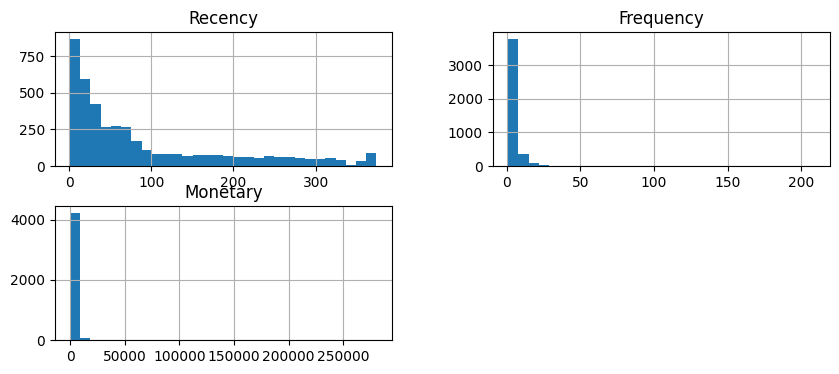

In [6]:
rfm[['Recency', 'Frequency', 'Monetary']].hist(bins=30, figsize=(10,4))
plt.show()


### SCALE RFM FEATURES

In [7]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


### CHOOSE NUMBER OF CLUSTERS

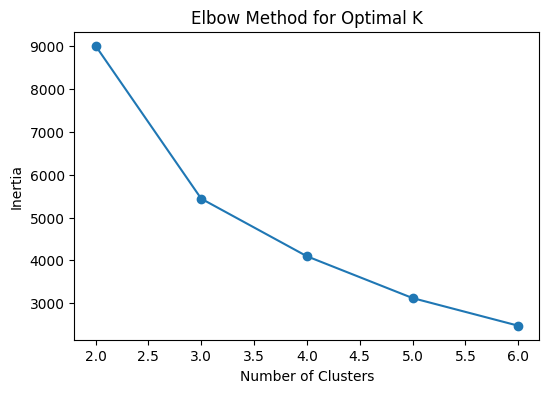

In [8]:
inertia = []

K = range(2, 7)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


### K-MEANS CLUSTERING

In [9]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,3
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,1


In [10]:
cluster_summary = rfm.groupby('Cluster').mean()
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1353.625312
1,248.075914,1.552015,478.848773
2,7.384615,82.538462,127187.959231
3,15.500000,22.333333,12690.500392


### VISUALIZATION

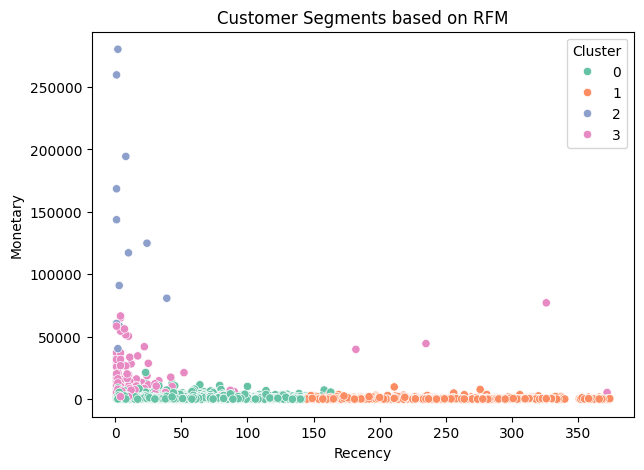

In [11]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=rfm['Recency'],
    y=rfm['Monetary'],
    hue=rfm['Cluster'],
    palette='Set2'
)
plt.title("Customer Segments based on RFM")
plt.show()


In [12]:
import joblib

joblib.dump(kmeans, '../models/rfm_kmeans.pkl')


['../models/rfm_kmeans.pkl']

### RFM Clustering Insights

- Customers were segmented into four distinct groups based on Recency, Frequency, and Monetary value.
- High-value customers exhibit low recency, high frequency, and high monetary contribution.
- Low-value customers show high recency and low spending behavior.
- These segments can be used for targeted marketing and personalized recommendations.
